The goal of this notebook is to take the generalized implementation in `MIPImplementation.ipynb` and apply it to several `tyche` technology examples to demonstrate functionality, problem size and complexity, and solution time and quality.

In [7]:
import os
import sys
sys.path.insert(0, os.path.abspath("../src"))

In [8]:
import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import seaborn           as sb
import tyche             as ty

from copy            import deepcopy
from IPython.display import Image 

In [9]:
import cProfile
import timeit

In [10]:
from mip import Model, MINIMIZE, MAXIMIZE, BINARY, xsum, OptimizationStatus
from itertools import product, combinations
from matplotlib.pyplot import hist

# Example 1a: Photovoltaic Module Efficiency

The data set is 8 x 8, with 8 investment categories (3 investment levels each) and 8 metrics of interest.

In this example, module efficiency is optimized (maximized) with investments into polysilicon, power electronics, and soft costs, with a constraint on hazardous waste, a total budget constraint, and individual budget constraints on each investment category.

In [11]:
designs = ty.Designs("data")
investments = ty.Investments("data")
designs.compile()
tranche_results = investments.evaluate_tranches(designs, sample_count=250)
results = investments.tranches.join(tranche_results.summary)
evaluator = ty.Evaluator(investments.tranches, tranche_results.summary)

Get the wide-format interpolated elicitation data from the Tyche Evaluator and reset the multi-level index.

In [12]:
wide = evaluator.evaluate_corners_wide().reset_index()

In [13]:
wide.head(26)

Index,CIGS,CdTe,GaAs,InGaP,Perovskite,Polysilicon,Power Electronics,Soft Costs,Capital,Efficiency,GHG,Hazardous,LCOE,Lifetime,Strategic,Yield
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.524277,2.068825,-0.003592,0.973497,-0.142384,188.015072,0.062962,10007.738557
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000000.0,-1.434266,2.069227,-0.003592,0.973060,-0.139568,188.015137,0.062962,10007.733655
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000000.0,-1.285396,2.066859,-0.003592,0.975591,-0.134910,188.015112,0.062962,10007.735899
3,0.0,0.0,0.0,0.0,0.0,0.0,1000000.0,0.0,-1.443752,2.069791,-0.003592,0.960839,-0.136197,188.015053,0.062962,10071.337222
4,0.0,0.0,0.0,0.0,0.0,0.0,1000000.0,1000000.0,-1.353741,2.070193,-0.003592,0.960401,-0.133381,188.015118,0.062962,10071.332319
5,0.0,0.0,0.0,0.0,0.0,0.0,1000000.0,5000000.0,-1.204872,2.067825,-0.003592,0.962933,-0.128723,188.015093,0.062962,10071.334564
6,0.0,0.0,0.0,0.0,0.0,0.0,5000000.0,0.0,-1.369106,2.068808,-0.003592,0.954539,-0.131754,188.015042,0.062962,10114.225750
7,0.0,0.0,0.0,0.0,0.0,0.0,5000000.0,1000000.0,-1.279095,2.069210,-0.003592,0.954101,-0.128938,188.015107,0.062962,10114.220847
8,0.0,0.0,0.0,0.0,0.0,0.0,5000000.0,5000000.0,-1.130225,2.066842,-0.003592,0.956632,-0.124280,188.015082,0.062962,10114.223092
9,0.0,0.0,0.0,0.0,0.0,2500000.0,0.0,0.0,-1.407054,2.080544,-0.003592,0.931548,-0.137529,188.015092,0.062962,10027.966714


In [14]:
categories = ['Polysilicon', 'Power Electronics', 'Soft Costs']

metric_obj = ['Efficiency']

metric_constraint = ['Hazardous']

Pull out the investment values and metric values from the data set.

In [15]:
# Investment levels = interval endpoints
inv_levels = wide.loc[:26,categories].values.tolist()

# Elicited metric values for objective function
m = wide.loc[:26,metric_obj].values.tolist()

# Elicited metric values for constraint
const = wide.loc[:26, metric_constraint].values.tolist()

# Number of endpoints
I = len(inv_levels)

(array([5., 1., 3., 0., 0., 0., 1., 4., 1., 3., 0., 0., 3., 3., 3.]),
 array([0.85676857, 0.86469007, 0.87261156, 0.88053305, 0.88845455,
        0.89637604, 0.90429754, 0.91221903, 0.92014053, 0.92806202,
        0.93598352, 0.94390501, 0.9518265 , 0.959748  , 0.96766949,
        0.97559099]),
 <BarContainer object of 15 artists>)

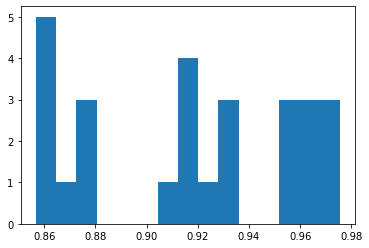

In [22]:
hist(wide.loc[:26, metric_constraint], bins=15)

Instantiate the MIP optimization problem.

In [107]:
example = Model(sense=MAXIMIZE)

Create continuous $\lambda$ variables with lower bound 0.0 and upper bound 1.0

In [108]:
lmbd_vars = []

for i in range(I):
    lmbd_vars += [example.add_var(name='lmbd_' + str(i), lb=0.0, ub=1.0)]

Create binary (integer) variables $y_{in_i}$ and constraints on $y$ and $\lambda$ that restrict optimal solutions to the intervals between endpoints (elicited data).

In [109]:
bin_vars = []
bin_count = 0

for i in range(I):
    for j in range(i, I):
        if j != i:
            # create binary variable
            bin_vars += [example.add_var(name='y_' + str(i) + str(j),
                                         var_type=BINARY)]
            # add binary/lambda variable constraint
            example += bin_vars[bin_count] <= lmbd_vars[i] + lmbd_vars[j], 'Interval_Constraint_' + str(i) + str(j)
            bin_count += 1

Define upper bound for total budget constraint and per-category upper bounds.

In [110]:
B = 3000000.0
max_amount = [3000000.0, 2300000.0, 3000000.0]
const_amount = 0.95

Create total budget constraint as a function of the $\lambda$ variables and the elicited investment levels from the data set.

In [111]:
example += xsum(lmbd_vars[i] * inv_levels[i][j] 
                for i in range(I)
                for j in range(len(inv_levels[i]))) <= B, 'Total_Budget'

Create constraints for budget within each investment category.

In [112]:
for j in range(len(categories)):
    example += xsum(lmbd_vars[i] * [el[j] for el in inv_levels][i] 
                    for i in range(I)) <= max_amount[j], 'Budget_for_' + categories[j].replace(' ', '')

Create minimum-metric constraint on the lambda variables.

In [113]:
example += xsum(lmbd_vars[i] * const[i][0] for i in range(I)) <= const_amount

Create two sets of constraints:
* Convexity constraints on $\lambda$ variables: the $\lambda$s must sum to 1.
* Constrain binary $y$ variables within each category such that the decision variables lie within exactly one interval.

In [114]:
example += sum(lmbd_vars) == 1, 'Lambda_Sum'

The sum over all binary variables is constrained to be exactly 1 to restrict optimal solutions to the linear intervals between endpoints (elicited data).

In [115]:
example += sum(bin_vars) == 1, 'Binary_Sum'

Create objective function: Metric objective as a function of $\lambda$s and elicited data.

In [116]:
example.objective = xsum(m[i][0] * lmbd_vars[i] for i in range(I))

Save model to a `lp` file for manual examination (optional; un-comment to save).

In [20]:
#example.write('example.lp')

Optimize.

In [117]:
status = example.optimize()

In [118]:
status

<OptimizationStatus.OPTIMAL: 0>

Print optimal objective function value, if a feasible solution was found, or an estimate for the objective function bound if no feasible solution was found.

In [119]:
if status == OptimizationStatus.OPTIMAL:
    print('optimal objective function value: ', example.objective_value)
elif status == OptimizationStatus.NO_SOLUTION_FOUND:
    print('objective function bound (estimate): ', example.objective_bound)
else:
    print('no solution found: ', status)

optimal objective function value:  2.0948990359828987


Get the optimal $\lambda$ and $y$ values. Store as separate lists and also print out.

In [120]:
lmbd_opt = []
y_opt = []

for v in example.vars:
    if 'lmbd' in v.name:
        lmbd_opt += [v.x]
    elif 'y' in v.name:
        y_opt += [v.x]
    if v.x > 1e-6:
        print('{} : {}'.format(v.name, v.x))

lmbd_0 : 0.33333333333333337
lmbd_18 : 0.6666666666666666
y_018 : 1.0


Calculate the optimal investment levels.

In [121]:
inv_levels_opt = {}

for i in range(len(categories)):
    inv_levels_opt[categories[i]] = sum([lmbd_opt[j] * [el[i] for el in inv_levels][j] 
                                         for j in range(len(lmbd_opt))])

inv_levels_opt

{'Polysilicon': 3000000.0, 'Power Electronics': 0.0, 'Soft Costs': 0.0}

Calculate the optimal total investment.

In [122]:
total_inv_levels_opt = sum(inv_levels_opt.values())
total_inv_levels_opt

3000000.0

# Example 1b: Photovoltaic Module [metric]